In [1]:
import numpy as np
import numpy.random as rand
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

#This is the binning we used in the paper
standard_binboundaries = np.concatenate((np.arange(0,25,25),
                                         np.arange(25,35,10),
                                         np.arange(35,215,5),
                                         np.arange(215,275,10),
                                         np.arange(275,300,25),
                                         np.arange(300,450,50),
                                         np.arange(450,560,100)))

#This class does std rescaling
class myscaler:
    
    def __init__(self, mybgdata):
        self.scale1 = preprocessing.StandardScaler().fit(mybgdata)
        tempdata = self.scale1.transform(mybgdata)
        self.mypca = PCA().fit(tempdata)
        tempdata = self.mypca.transform(tempdata)
        self.scale2 = preprocessing.StandardScaler().fit(tempdata)
        
    def transform(self,inputdata):
        return np.dot(self.scale2.transform(self.mypca.transform(self.scale1.transform(inputdata))),
                      self.mypca.components_)

#This class does PCA rescaling
class mysplit_n_scale:
    
    def __init__(self, mybgdata, mybinboundaries = standard_binboundaries):
        self.binboundaries = mybinboundaries
        bgdatabinned = []
        for i in range(0,len(mybinboundaries)-1):
            bgdatabinned.append(
                np.array([myrow[1:] for myrow in mybgdata if (myrow[0] < mybinboundaries[i+1] and myrow[0] >= mybinboundaries[i])])
            )
        
        self.scale1 = [preprocessing.StandardScaler().fit(databin) for databin in bgdatabinned]
        tempdata = [self.scale1[i].transform(databin) for i, databin in enumerate(bgdatabinned)]
        self.mypca = [PCA().fit(tempdatarow) for tempdatarow in tempdata]
        newtempdata = [self.mypca[i].transform(tempdatarow) for i, tempdatarow in enumerate(tempdata)]
        self.scale2 = [preprocessing.StandardScaler().fit(tempdatarow) for tempdatarow in newtempdata]
        
    def transform(self,inputdata):
        inputdatabinned = []
        for i in range(0,len(self.binboundaries)-1):
            inputdatabinned.append(
                np.array([myrow[1:] for myrow in inputdata
                         if (myrow[0] < self.binboundaries[i+1] and myrow[0] >= self.binboundaries[i])])
            )
        scaleddatabinned = [np.dot(self.scale2[i].transform(self.mypca[i].transform(self.scale1[i].transform(inputdatarow))),
                                    self.mypca[i].components_)
                            if len(inputdatarow) > 0 else []
                            for i, inputdatarow in enumerate(inputdatabinned)]
        return scaleddatabinned

In [2]:
#Load data
data_prefix = './no-mass-cut-data/'
bg_nameg = 'Zg-PT1000'
bg_nameq = 'Zq-PT1000'

bgdatag = np.loadtxt(data_prefix + bg_nameg + '.all.dat')
bgdataq = np.loadtxt(data_prefix + bg_nameq + '.all.dat')

#Take a 50/50 mix of quark and gluon data
minlength = min(len(bgdatag),len(bgdataq))
bgdata = np.append(bgdatag[:minlength+1],bgdataq[:minlength+1],axis=0)
#Randomize ordering
rand.shuffle(bgdata)

In [3]:
#Initialize the PCA preprocessor
preprocessor = mysplit_n_scale(bgdata)
#PCA preprocess data. This results in a binned dataset
bgdatabinned = preprocessor.transform(bgdata)

In [4]:
binboundaries = standard_binboundaries
bincenters = [0.5*(binboundaries[i+1] + binboundaries[i]) for i in range(0,len(binboundaries)-1)]
binwidths = [binboundaries[i+1] - binboundaries[i] for i in range(0,len(binboundaries)-1)]
bincontents = [len(myrow) for myrow in bgdatabinned]
bindensities = [bincontents[i] / binwidths[i] for i in range(0,len(binwidths))]
print(list(enumerate(binboundaries)))
print(list(enumerate(bincenters)))
print(list(enumerate(bincontents)))

[(0, 0), (1, 25), (2, 35), (3, 40), (4, 45), (5, 50), (6, 55), (7, 60), (8, 65), (9, 70), (10, 75), (11, 80), (12, 85), (13, 90), (14, 95), (15, 100), (16, 105), (17, 110), (18, 115), (19, 120), (20, 125), (21, 130), (22, 135), (23, 140), (24, 145), (25, 150), (26, 155), (27, 160), (28, 165), (29, 170), (30, 175), (31, 180), (32, 185), (33, 190), (34, 195), (35, 200), (36, 205), (37, 210), (38, 215), (39, 225), (40, 235), (41, 245), (42, 255), (43, 265), (44, 275), (45, 300), (46, 350), (47, 400), (48, 450), (49, 550)]
[(0, 12.5), (1, 30.0), (2, 37.5), (3, 42.5), (4, 47.5), (5, 52.5), (6, 57.5), (7, 62.5), (8, 67.5), (9, 72.5), (10, 77.5), (11, 82.5), (12, 87.5), (13, 92.5), (14, 97.5), (15, 102.5), (16, 107.5), (17, 112.5), (18, 117.5), (19, 122.5), (20, 127.5), (21, 132.5), (22, 137.5), (23, 142.5), (24, 147.5), (25, 152.5), (26, 157.5), (27, 162.5), (28, 167.5), (29, 172.5), (30, 177.5), (31, 182.5), (32, 187.5), (33, 192.5), (34, 197.5), (35, 202.5), (36, 207.5), (37, 212.5), (38, 

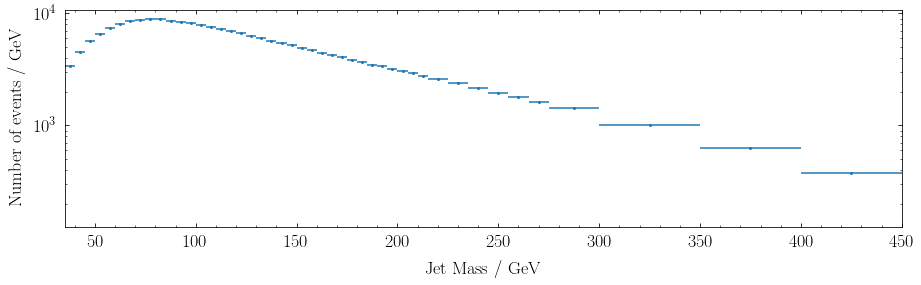

In [5]:
#Here we will plot the QCD jet mass distribution in this sample

axislabelsize = 18

yerr = np.divide(1,np.sqrt(np.array(bincontents)))
xerr = np.multiply(0.5,np.array(binwidths))
plt.figure(figsize=(15,4))
plt.semilogy()
plt.xlim(35,450)
plt.errorbar(bincenters, bindensities, xerr=xerr, yerr=yerr,fmt='o',markersize=2)
plt.xlabel('Jet Mass / GeV', size=axislabelsize)
plt.ylabel('Number of events / GeV', size=axislabelsize)
plt.show()

In [44]:
#Now I am going to select a sample for training and validation.
#I will use only the first 20% of the original dataset.
#I will also only select events within the mass window 65 to 105 GeV.

bgdatabinned_train_and_val = preprocessor.transform(bgdata[:int(len(bgdata)*0.2)])
bgdatabinned_test = preprocessor.transform(bgdata[int(len(bgdata)*0.2):])

bgdata65to105masswindow = np.array(bgdatabinned_train_and_val[8])
for i in range(9,16):
    bgdata65to105masswindow = np.append(bgdata65to105masswindow,bgdatabinned_train_and_val[i],axis=0)
rand.shuffle(bgdata65to105masswindow)
print(len(bgdata65to105masswindow))

68328


In [7]:
#Import some MI data as signal template for training
#The signal is already selected only within the 65 to 105 GeV mass window.

data_prefix = './Input-Data/PT1000/'
sigPnames = ['R2200-M80-2P_u',
            'R2200-M80-3P_udd',
            'R2200-M80-4P_u',
            'R2200-M80-2P_b',
            'R2200-M80-3P_ubb',
            'R2200-M80-4P_b'
           ]

sigPdatalist = [np.loadtxt(data_prefix + filename + '.all.dat') for filename in sigPnames]
sigPlengthmin = min([len(array) for array in sigPdatalist])
print("Smallest signal dataset:",sigPlengthmin)
numtotsig = len(sigPdatalist)*sigPlengthmin
#We arbitrarily chose to train on equal amounts of each MI data category,
#this means that the max data available for this is determined by the smallest
#signal category
print("Max signal available:",numtotsig)

#We will want to train on equal signal and background, which might limit the amount of
#signal data we can use
numpersignal = min(math.floor(len(bgdata65to105masswindow)/6),sigPlengthmin)
print("Number of signal events to be used:",numpersignal*6)
sigPdatainput = np.stack([dataset[:numpersignal] for dataset in sigPdatalist])
sigPdatainput = sigPdatainput.reshape((len(sigPdatainput)*len(sigPdatainput[0]),-1),order='F')

sigdatascaledbinned = preprocessor.transform(sigPdatainput)
sigdata = np.array([entry for sublist in sigdatascaledbinned if len(sublist) > 0 for entry in sublist])

Smallest signal dataset: 25959
Max signal available: 155754
Number of signal events to be used: 68328


In [8]:
#Now to prepare training and validation data sets

rand.shuffle(bgdata65to105masswindow)
rand.shuffle(sigdata)
valid_no = math.floor(len(sigdata)*0.2)
train_no = len(sigdata) - valid_no
test_no = len(bgdata65to105masswindow) - len(sigdata)
test_frac = test_no / len(bgdata65to105masswindow)
print('Training size = ', train_no)
print('Validation size = ', valid_no)


bgdata65to105masswindow_test = bgdata65to105masswindow[:test_no]
bgdata65to105masswindow_train = bgdata65to105masswindow[test_no:train_no + test_no]
bgdata65to105masswindow_val = bgdata65to105masswindow[test_no+train_no:test_no+train_no+valid_no]

sigdata_train = sigdata[:train_no]
sigdata_val = sigdata[train_no:valid_no+train_no]


data_train = np.append(bgdata65to105masswindow_train,
                       sigdata_train,
                       axis=0)
labels_train = np.append(np.zeros(train_no),np.ones(train_no))

data_val = np.append(bgdata65to105masswindow_val,sigdata_val,axis=0)
labels_val = np.append(np.zeros(valid_no),np.ones(valid_no))

perms_train = rand.permutation(2*train_no)
data_train = data_train[perms_train]
labels_train = labels_train[perms_train]

perms_val = rand.permutation(2*valid_no)
data_val = data_val[perms_val]
labels_val = labels_val[perms_val]

Training size =  54663
Validation size =  13665


In [14]:
#This is just to decide how big a basis of N-subjettiness variables to use.
#We used seven body in the paper, but actually we were finding saturation already at six body.
#It turns out that tau_1^2 = (jet mass / pT)^2 identically, so probably it is actually best to remove this variable.
twobody = [0,6]
threebody = [0,1,6,6+1,2*6]
fourbody = [0,1,2,6,6+1,6+2,2*6,2*6+1]
fivebody = [0,1,2,3,6,6+1,6+2,6+3,2*6,2*6+1,2*6+2]
sixbody = [0,1,2,3,4,6,6+1,6+2,6+3,6+4,2*6,2*6+1,2*6+2,2*6+3]
sixbody_without_tau12 = [0,1,2,3,4,6+1,6+2,6+3,6+4,2*6,2*6+1,2*6+2,2*6+3]
sevenbody = [0,1,2,3,4,5,6,6+1,6+2,6+3,6+4,6+5,2*6,2*6+1,2*6+2,2*6+3,2*6+4]
sevenbody_without_tau12 = [0,1,2,3,4,5,6+1,6+2,6+3,6+4,6+5,2*6,2*6+1,2*6+2,2*6+3,2*6+4]

In [15]:
#Now let's train a NN! This block specifies the parameters I will use

import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pickle as pickle
import tensorflow as tf

early_stopping = EarlyStopping(monitor='val_loss', patience=5,verbose=1)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', patience=3,verbose=1)

#tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
#                 histogram_freq=5, 
#                 write_graph=True, 
#                 write_images=True)

mycallbacks=[early_stopping, reduce_LR]
batch_size=500

models = {}
models_hist = {}

ntries = 5

sig_predict={}
bg_predict={}

In [104]:
#Either load existing NN model in this block, or use the next block to train a new one
model_name = 'jet_mass_1000_80_sixbody_notau12'
from keras.models import load_model
models[model_name] = load_model('./saved_models/' + model_name + '.h5')

In [17]:
#Train baby, train!
#This will train five times and pick the very best.

model_name = 'jet_mass_1000_80_sixbody_notau12'
#Use the full seven body basis of N-subjettiness variables, except without 
use_vars=sixbody_without_tau12
numvars=len(use_vars)
aucs = list()
aucmax=0
for i in range(ntries):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=numvars))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    model_hist = model.fit(data_train[:,use_vars], labels_train, epochs=100, batch_size=batch_size,
                        validation_data=(data_val[:,use_vars],labels_val),callbacks=mycallbacks,verbose=1)

    newauc = roc_auc_score(labels_val,model.predict(data_val[:,use_vars]))
    aucs.append(newauc)
    print(newauc)
    if newauc > aucmax:
        aucmax = newauc
        
        models[model_name] = model
        models_hist[model_name] = model_hist
        
print(aucs)

#Save the model
models[model_name].save('./saved_models/'+model_name+'.h5')
with open('./saved_models/hist_'+model_name, 'wb') as file_pi:
    pickle.dump(models_hist[model_name].history, file_pi)
    
with open('./saved_models/hist_jet_mass_1000_80_final', 'wb') as file_pi:
    pickle.dump(models_hist[model_name].history, file_pi)
    
# sig_predict[model_name] = models[model_name].predict(sigdata_test[:,use_vars])
# bg_predict[model_name] = models[model_name].predict(bgdata_test[:,use_vars])

Train on 109326 samples, validate on 27330 samples
Epoch 1/100
109326/109326 [==============================] - 1s - loss: 0.3855 - acc: 0.8338 - val_loss: 0.3557 - val_acc: 0.8447
Epoch 2/100
109326/109326 [==============================] - 1s - loss: 0.3562 - acc: 0.8468 - val_loss: 0.3506 - val_acc: 0.8488
Epoch 3/100
109326/109326 [==============================] - 1s - loss: 0.3529 - acc: 0.8483 - val_loss: 0.3495 - val_acc: 0.8494
Epoch 4/100
109326/109326 [==============================] - 1s - loss: 0.3515 - acc: 0.8488 - val_loss: 0.3478 - val_acc: 0.8496
Epoch 5/100
109326/109326 [==============================] - 1s - loss: 0.3502 - acc: 0.8495 - val_loss: 0.3467 - val_acc: 0.8505
Epoch 6/100
109326/109326 [==============================] - 1s - loss: 0.3493 - acc: 0.8501 - val_loss: 0.3475 - val_acc: 0.8508
Epoch 7/100
109326/109326 [==============================] - 1s - loss: 0.3480 - acc: 0.8505 - val_loss: 0.3465 - val_acc: 0.8501
Epoch 8/100
109326/109326 [============

109326/109326 [==============================] - 0s - loss: 0.3492 - acc: 0.8496 - val_loss: 0.3471 - val_acc: 0.8490
Epoch 7/100
109326/109326 [==============================] - 0s - loss: 0.3478 - acc: 0.8504 - val_loss: 0.3475 - val_acc: 0.8499
Epoch 8/100
109326/109326 [==============================] - 0s - loss: 0.3472 - acc: 0.8511 - val_loss: 0.3444 - val_acc: 0.8519
Epoch 9/100
109326/109326 [==============================] - 0s - loss: 0.3460 - acc: 0.8509 - val_loss: 0.3435 - val_acc: 0.8513
Epoch 10/100
109326/109326 [==============================] - 0s - loss: 0.3451 - acc: 0.8515 - val_loss: 0.3428 - val_acc: 0.8516
Epoch 11/100
109326/109326 [==============================] - 0s - loss: 0.3443 - acc: 0.8524 - val_loss: 0.3437 - val_acc: 0.8520
Epoch 12/100
109326/109326 [==============================] - 0s - loss: 0.3438 - acc: 0.8521 - val_loss: 0.3429 - val_acc: 0.8525
Epoch 13/100
109326/109326 [==============================] - 0s - loss: 0.3431 - acc: 0.8525 - val

109326/109326 [==============================] - 1s - loss: 0.3405 - acc: 0.8536 - val_loss: 0.3426 - val_acc: 0.8520
Epoch 16/100
109326/109326 [==============================] - 1s - loss: 0.3403 - acc: 0.8538 - val_loss: 0.3426 - val_acc: 0.8521
Epoch 17/100
109326/109326 [==============================] - 1s - loss: 0.3403 - acc: 0.8535 - val_loss: 0.3428 - val_acc: 0.8517
Epoch 18/100
109326/109326 [==============================] - 1s - loss: 0.3401 - acc: 0.8538 - val_loss: 0.3424 - val_acc: 0.8525
Epoch 19/100
109326/109326 [==============================] - 1s - loss: 0.3401 - acc: 0.8538 - val_loss: 0.3426 - val_acc: 0.8522
Epoch 20/100
109326/109326 [==============================] - 1s - loss: 0.3399 - acc: 0.8538 - val_loss: 0.3425 - val_acc: 0.8522
Epoch 21/100
109326/109326 [==============================] - 1s - loss: 0.3398 - acc: 0.8538 - val_loss: 0.3423 - val_acc: 0.8523
Epoch 22/100
109326/109326 [==============================] - 0s - loss: 0.3397 - acc: 0.8539 - 

0.92838611011
Train on 109326 samples, validate on 27330 samples
Epoch 1/100
109326/109326 [==============================] - 1s - loss: 0.3808 - acc: 0.8359 - val_loss: 0.3539 - val_acc: 0.8472
Epoch 2/100
109326/109326 [==============================] - 1s - loss: 0.3554 - acc: 0.8471 - val_loss: 0.3499 - val_acc: 0.8491
Epoch 3/100
109326/109326 [==============================] - 1s - loss: 0.3530 - acc: 0.8484 - val_loss: 0.3493 - val_acc: 0.8490
Epoch 4/100
109326/109326 [==============================] - 1s - loss: 0.3510 - acc: 0.8495 - val_loss: 0.3493 - val_acc: 0.8479
Epoch 5/100
109326/109326 [==============================] - 1s - loss: 0.3496 - acc: 0.8497 - val_loss: 0.3479 - val_acc: 0.8499
Epoch 6/100
109326/109326 [==============================] - 1s - loss: 0.3484 - acc: 0.8506 - val_loss: 0.3476 - val_acc: 0.8502
Epoch 7/100
109326/109326 [==============================] - 1s - loss: 0.3471 - acc: 0.8510 - val_loss: 0.3482 - val_acc: 0.8506
Epoch 8/100
109326/109326

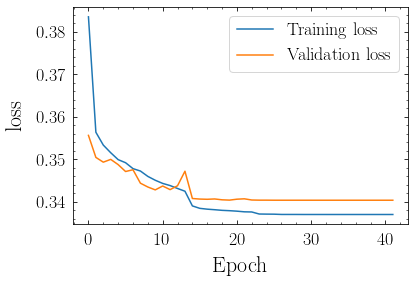

In [45]:
#Let's plot loss during training
plt.close('all')

for key in models_hist:
    plt.plot(models_hist[key].history['loss'],label='Training loss')
    plt.plot(models_hist[key].history['val_loss'],label='Validation loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

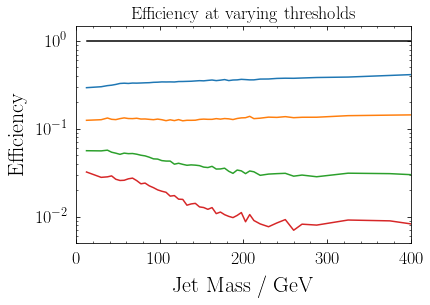

In [90]:
mymodel=models['jet_mass_1000_80_sixbody_notau12']
bgpredicttable = [mymodel.predict(data[:,sixbody_without_tau12]) for data in bgdatabinned_test]

thresholds = [0,0.2,0.55,0.8,0.89]
binefficiencies = [
    [np.count_nonzero(predictions > threshold)/len(predictions) for predictions in bgpredicttable]
    for threshold in thresholds
]
bincutcounts = [
    [np.count_nonzero(predictions > threshold) for predictions in bgpredicttable]
    for threshold in thresholds
]

plt.close('all')
colours=('k','C0','C1','C2','C3')
for i in range(0,len(thresholds)):
    plt.plot(bincenters,binefficiencies[i],color=colours[i])
plt.semilogy()
plt.xlim([0,400])
plt.ylim([0.005,1.5])
plt.xlabel('Jet Mass / GeV')
plt.ylabel('Efficiency')
plt.title('Efficiency at varying thresholds')
plt.show()

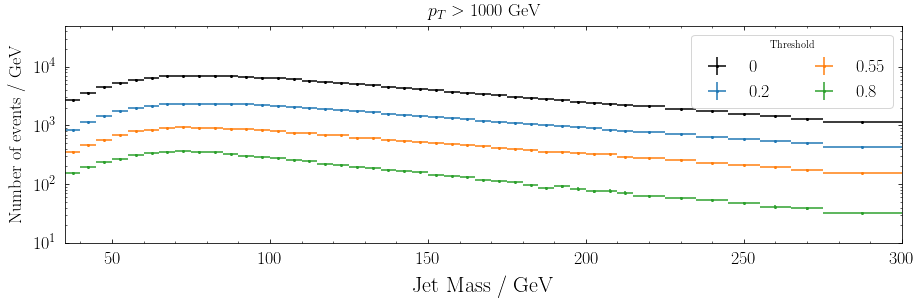

In [91]:
#Let's plot QCD jet mass distribution after tagging at various thresholds
threshold_choices=[0,1,2,3]

axislabelsize = 18

plt.close('all')
plt.figure(figsize=(15,4))

colours=('k','C0','C1','C2','C3')

yerr0 = np.multiply(np.divide(np.sqrt(np.add(np.array(bincontents),1)),binwidths),0.89)
yerrs = np.divide(np.sqrt(np.add(np.array(bincutcounts),1)),binwidths)
xerr = np.multiply(0.5,np.array(binwidths))

plt.semilogy()
plt.ylim(10,5e4)
plt.xlim(35,300)
plt.xlabel('Jet Mass / GeV')
plt.ylabel('Number of events / GeV', size=axislabelsize)
plt.title(r'$p_T > 1000$ GeV', size=axislabelsize)
for i in range(0,len(threshold_choices)):
    #yerr = np.sqrt(np.add(np.array(bincutcounts[i]),1))
    plt.errorbar(bincenters,np.divide(bincutcounts[threshold_choices[i]],binwidths),
                 xerr=xerr, yerr=yerrs[threshold_choices[i]],fmt='o',markersize=2,
                 color=colours[i],label=thresholds[i])
plt.legend(title='Threshold',ncol=2)
plt.show()

In [105]:
#Lets import some signals to make a plot of the tagger acting on bg + signal

signal100 = preprocessor.transform(np.loadtxt('no-mass-cut-data/R2200-M100-AA40_b.all.dat'))
signal200 = preprocessor.transform(np.loadtxt('no-mass-cut-data/R2200-M200-WWhad.all.dat'))
sig100predicttable = [mymodel.predict(data[:,sixbody_without_tau12]) if len(data) > 0 else np.array([0.])
                      for data in signal100]
sig200predicttable = [mymodel.predict(data[:,sixbody_without_tau12]) if len(data) > 0 else np.array([0.])
                      for data in signal200]
sigbincontents200 = [len(row) for row in signal200]
sigbincontents100 = [len(row) for row in signal100]

sig100binefficiencies = [
    [np.count_nonzero(predictions > threshold)/len(predictions) for predictions in sig100predicttable]
    for threshold in thresholds
]
sig100bincutcounts = [
    [np.count_nonzero(predictions > threshold) for predictions in sig100predicttable]
    for threshold in thresholds
]
sig100bincutdensities = np.divide(sig100bincutcounts,binwidths)

sig200binefficiencies = [
    [np.count_nonzero(predictions > threshold)/len(predictions) for predictions in sig200predicttable]
    for threshold in thresholds
]
sig200bincutcounts = [
    [np.count_nonzero(predictions > threshold) for predictions in sig200predicttable]
    for threshold in thresholds
]
sig200bincutdensities = np.divide(sig200bincutcounts,binwidths)

sigplusbgcut = [np.add(np.add(np.multiply(sig200bincutcounts[i],0.25),
                       np.array(bincutcounts[i])),
                       np.multiply(sig100bincutcounts[i],0.6))
                for i in range(0,len(bincutcounts))]

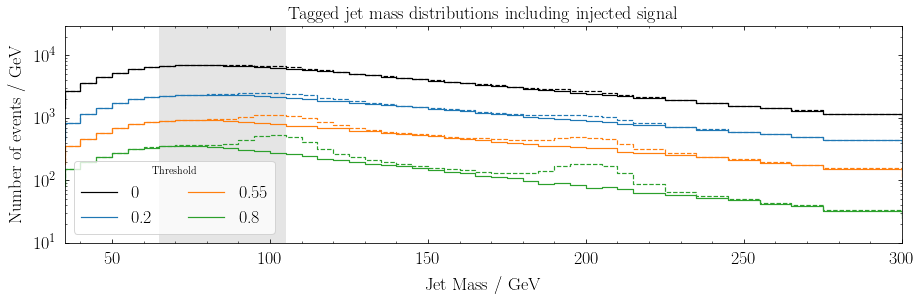

In [103]:
#Now lets plot that bitch!

axislabelsize = 18

plt.close('all')

threshold_choices=[0,1,2,3]
colours=['k','C0','C1','C2','C3']

plt.figure(figsize=(15,4))


yerr0 = np.multiply(np.divide(np.sqrt(np.add(np.array(bincontents),1)),binwidths),0.89)
yerrs = np.divide(np.sqrt(np.add(np.array(bincutcounts),1)),binwidths)
xerr = np.multiply(0.5,np.array(binwidths))

axes2d[0].semilogy()
axes2d[0].axvspan(65, 105, alpha=0.2, facecolor='gray')
axes2d[0].set_ylim(10,3e4)
axes2d[0].set_xlim(35,300)
#plt.xlabel('Jet Mass / GeV')
axes2d[0].set_ylabel('Number of events / GeV', size=axislabelsize)
axes2d[0].set_title(r'$p_T > 1000$ GeV', size=axislabelsize)
axes2d[0].errorbar(bincenters, np.multiply(bindensities,0.8), xerr=xerr, yerr=yerr0,fmt='o',markersize=2,color='k')
for i in range(0,len(threshold_choices)):
    #yerr = np.sqrt(np.add(np.array(bincutcounts[i]),1))
    axes2d[0].errorbar(bincenters,np.divide(bincutcounts[threshold_choices[i]],binwidths),
                 xerr=xerr, yerr=yerrs[threshold_choices[i]],fmt='o',markersize=2,color=colors[i])

linewidth=1.2
plt.semilogy()
plt.ylim(10,3e4)
plt.xlim(35,300)
plt.axvspan(65, 105, alpha=0.2, facecolor='gray')
plt.xlabel('Jet Mass / GeV', size=axislabelsize)
plt.ylabel('Number of events / GeV', size=axislabelsize)
#plt.title(r'$p_T > 500$ GeV')
for i in range(0,len(threshold_choices)):
    plt.step(binboundaries[:len(binboundaries)-1],
            np.divide(bincutcounts[threshold_choices[i]],binwidths),
            where='post',color=colours[i],linewidth=linewidth,label=thresholds[i])
    
for i in range(0,len(threshold_choices)):
    plt.step(binboundaries[:len(binboundaries)-1],
             np.divide(sigplusbgcut[threshold_choices[i]],binwidths),
             where='post',color=colours[i],linestyle='--',linewidth=linewidth)
plt.legend(title='Threshold',ncol=2)
plt.title('Tagged jet mass distributions including injected signal')
plt.show()